In [1]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT, process_Danenberg_clinical_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test


### Parameters

In [2]:
iteration = 2
PhenoGraph_k =  200
node_label = 'TMECellType'
size_smallest_cluster  = 10
survival_type = 'Disease-specific'
PopulationGraph_type = 'two_step_knn_graph'
para_dict = {
    'weight_threshold_percentile': 95,
    'knn_k': 30
}
patient_filtering_dict = {
      'Clinical Subtype': 'TNBC'
}

# Discovery

### Load Gram matrix and clinical data

In [3]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]
Histograms = Histograms/np.sum(Histograms, axis=1, keepdims=True)

clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical = process_Danenberg_clinical_data(clinical)
Patient_Inclusion_mask = np.ones(len(Patient_IDs), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs]
    patient_inclusion_mask = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask = Patient_Inclusion_mask * patient_inclusion_mask
Patient_IDs = np.array(Patient_IDs)[Patient_Inclusion_mask]
Gram_matrix = Gram_matrix[Patient_Inclusion_mask, :][:, Patient_Inclusion_mask]
Histograms = Histograms[Patient_Inclusion_mask, :]
print("{} patients are included".format(len(Patient_IDs)))

50 patients are included


### Community detection

In [4]:

# Histograms = Histograms[Indices, :]
print(Gram_matrix.shape)
# Gram_matrix[Gram_matrix<0.75] = 0
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)

Community_ids = detect_communities(G_population, size_smallest_cluster, resolution = 1)


(50, 50)


In [5]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])
for i in range(1, int(np.max(Community_ids)+1)):
    Gram_matrix_ = Gram_matrix[Community_ids == i, :][:, Community_ids == i]
    # if caculate_mutual_similarity(Gram_matrix_) < 2* caculate_mutual_similarity(Gram_matrix):
    #     Community_ids[Community_ids == i] = 0
    print("{} subgroup {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], i, caculate_mutual_similarity(Gram_matrix_)))

print("Overall {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix.shape[0], caculate_mutual_similarity(Gram_matrix)))



28 subgroup 1 patients, averaged Intra-group similarity is 0.40 
22 subgroup 2 patients, averaged Intra-group similarity is 0.31 
Overall 50 patients, averaged Intra-group similarity is 0.26 


### Survival analysis for subgroups

In [6]:
Length = [clinical.loc[clinical['patient_id'] == i, survival_type+ ' Survival (Months)'].values[0] for i in Patient_IDs]
Status = [clinical.loc[clinical['patient_id'] == i,  survival_type+ ' Survival Status'].values[0] for i in Patient_IDs]  
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
print("{} patients are included".format(len(Patient_IDs_)))
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_ == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("\tSignificant")

50 patients are included
S1 (N = 22):
Survival: hr = 2.4274687838837234, p = 0.03890696526213793
S2 (N = 28):
Survival: hr = 0.4119517444010519, p = 0.03890696526213793


### Plot population graph

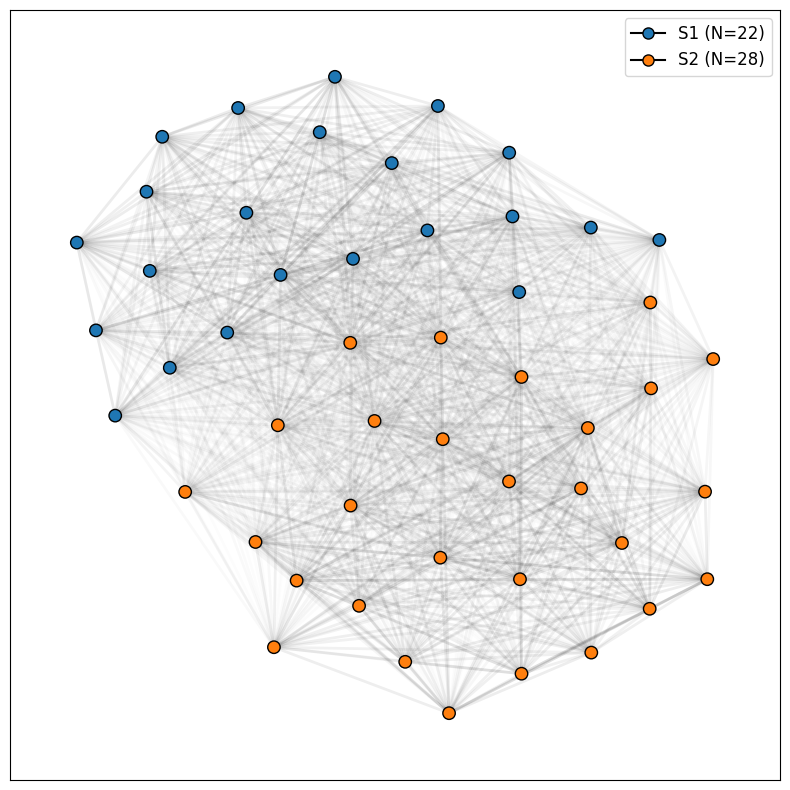

In [7]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    'two_step_knn_graph',
    para_dict = {
        'weight_threshold_percentile': 90,
        'knn_k':20
    },
)
color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
pos = nx.spring_layout(G_population, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
edge_list = list(G_population.edges())
edge_alpha = [
        0.1 * G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0 else 0 for u, v in edge_list
    ]
nx.draw_networkx_edges(G_population, pos, alpha=edge_alpha, width=2)
nx.draw_networkx_nodes(
            G_population, pos, node_size=80, 
            node_color=[color_palette[int(i)] for i in Subgroup_ids_], 
            edgecolors="black"
        )
if np.sum(Subgroup_ids_ == 0)>0:
    handles = [
        Line2D(
            [0],
            [0],
            marker="o",
            color = 'k',
            label=f"Unclassified (N={np.sum(Subgroup_ids_ == 0)})",
            markerfacecolor=color_palette[0],
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    ]
else:
    handles = []
for i in range(1, len(np.unique(Subgroup_ids_[Subgroup_ids_!=0]))+1):
    patch = Line2D(
        [0],
        [0],
        marker="o",
        color = 'k',
        label=f"S{i} (N={np.sum(Subgroup_ids_ == i)})",
        markerfacecolor=color_palette[i],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
    handles.append(patch)
ax.legend(handles=handles, fontsize = 12)
plt.show()

### Plot hazard ratio

/tmp/ipykernel_4072718/2360561340.py:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set(ylim = (0,10))


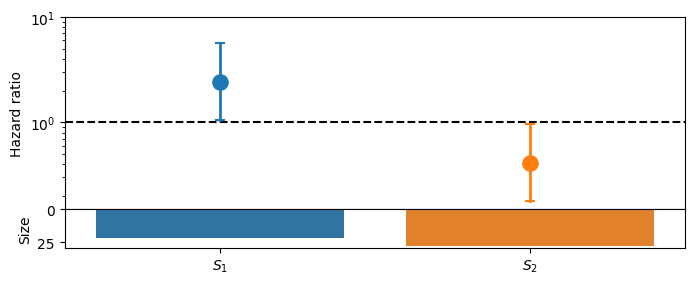

In [8]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids_ == subgroup_id))
    xticklabels.append("$S_{}$".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
ax[0].set(ylim = (0,10))
plt.show()

### Plot K-M Plot

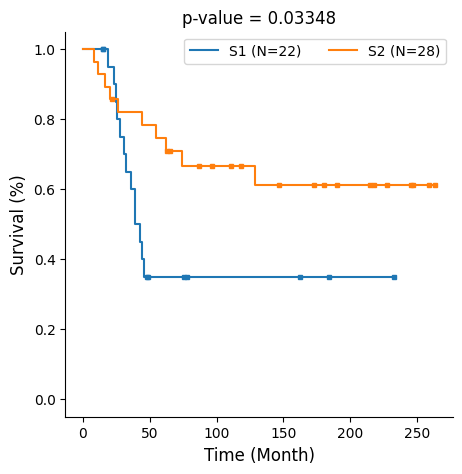

In [9]:
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    length_A, event_observed_A = (
            Length_[Subgroup_ids_ == subgroup_id],
            Status_[Subgroup_ids_ == subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], np.sum(Subgroup_ids_ == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})
log_rank_test  = multivariate_logrank_test(
        Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
    )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

# Validation

## Subset 2

#### Load Gram matrix and clinical data

In [10]:
SoftWL_dict_cohort2 = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_cohort2 = SoftWL_dict_cohort2["Patient_id"]
Histograms_cohort2 = SoftWL_dict_cohort2["Histogram"]
Histograms_cohort2 = Histograms_cohort2/np.sum(Histograms_cohort2, axis=1, keepdims=True)

Patient_Inclusion_mask_cohort2 = np.ones(len(Patient_IDs_cohort2), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_cohort2]
    patient_inclusion_mask_cohort2 = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_cohort2 = Patient_Inclusion_mask_cohort2 * patient_inclusion_mask_cohort2
Patient_IDs_cohort2 = np.array(Patient_IDs_cohort2)[Patient_Inclusion_mask_cohort2]
Histograms_cohort2 = Histograms_cohort2[Patient_Inclusion_mask_cohort2, :]
print("{} patients are included".format(len(Patient_IDs_cohort2)))

Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival Status'].values[0] for i in Patient_IDs_cohort2]  
DF_cohort2 = pd.DataFrame({"Length": Length_cohort2, "Status": Status_cohort2}).dropna()
Length_cohort2_ = np.array(DF_cohort2["Length"])
Status_cohort2_ = np.array(DF_cohort2["Status"])
Histograms_cohort2_ = Histograms_cohort2[DF_cohort2.index.values, :]
Patient_IDs_cohort2_ = np.array(Patient_IDs_cohort2)[DF_cohort2.index.values]

31 patients are included


#### Map subgroup ids

In [11]:
from b_Soft_WL_Kernel_random_split.SoftWL import get_Gram_matrix
from Alignment import centroid_alignment_based_on_similarity
Gram_matrix_cohort2_ = get_Gram_matrix(Histograms_cohort2_)

Indices = np.zeros(len(Histograms_), dtype=bool)
Similarity_cohort2_discovery = get_Gram_matrix(np.concatenate([Histograms_cohort2_, Histograms_], axis=0))
Similarity_cohort2_discovery = Similarity_cohort2_discovery[:Histograms_cohort2_.shape[0], :][:, Histograms_cohort2_.shape[0]:]
assert Similarity_cohort2_discovery.shape[0] == Histograms_cohort2_.shape[0]
Subgroup_ids_cohort2_ = centroid_alignment_based_on_similarity(Similarity_cohort2_discovery, Subgroup_ids_, k=1, quality_control_threshold = 0)
print("{} patients are included".format(len(Patient_IDs_cohort2_)))

0.5411527057042105
31 patients are included


#### Plot population graph

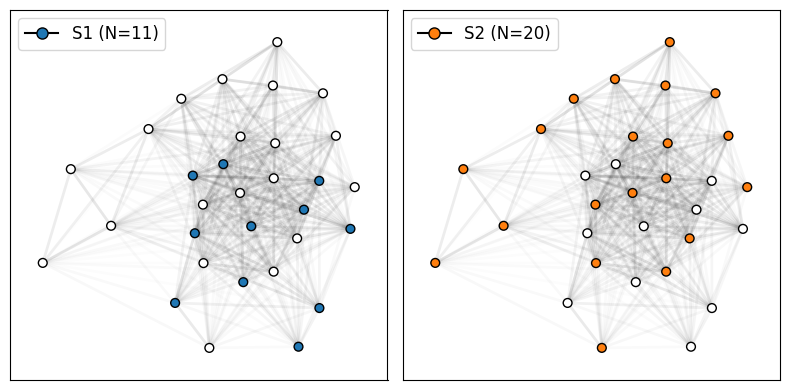

In [12]:
G_population_cohort2_ = construct_PopulationGraph(
    Gram_matrix_cohort2_,
    'knn_graph',
    para_dict = {
        'weight_threshold_percentile': 90,
        'knn_k':20
    },
)
color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
pos = nx.spring_layout(G_population_cohort2_, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(1, Subgroup_ids_cohort2_.shape[1], figsize=(4*Subgroup_ids_cohort2_.shape[1],4), tight_layout=True)
for i in range(Subgroup_ids_cohort2_.shape[1]):
    subgroup_id = i + 1
    edge_list = list(G_population_cohort2_.edges())
    edge_alpha = [
            0.1 * G_population_cohort2_[u][v]["weight"] if G_population_cohort2_[u][v]["weight"] > 0 else 0 for u, v in edge_list
        ]
    nx.draw_networkx_edges(G_population_cohort2_, pos, alpha=edge_alpha, width=2, ax = ax[i])
    nx.draw_networkx_nodes(
                G_population_cohort2_, pos, node_size=40, 
                node_color=[color_palette[subgroup_id] if j==1 else 'white' for j in Subgroup_ids_cohort2_[:,i]], 
                edgecolors="black", ax = ax[i]
            )
    handles = [Line2D(
            [0],
            [0],
            marker="o",
            color = 'k',
            label=f"S{subgroup_id} (N={np.sum(Subgroup_ids_cohort2_[:,i] == 1)})",
            markerfacecolor=color_palette[i+1],
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )]
    ax[i].legend(handles=handles, fontsize = 12)
plt.show()

#### Survival analysis

In [13]:
Length = [clinical.loc[clinical['patient_id'] == i, survival_type+ ' Survival (Months)'].values[0] for i in Patient_IDs_cohort2_]
Status = [clinical.loc[clinical['patient_id'] == i,  survival_type+ ' Survival Status'].values[0] for i in Patient_IDs_cohort2_]  
HR = []
for i in range(Subgroup_ids_cohort2_.shape[1]):
    if np.sum(Subgroup_ids_cohort2_[:,i] == 1) > 10:
        HR_ = calculate_hazard_ratio(Length, Status, Subgroup_ids_cohort2_[:,i])
        HR.append({
            'subgroup_id': i + 1,
            'hr': HR_[0]['hr'],
            'hr_lower': HR_[0]['hr_lower'],
            'hr_upper': HR_[0]['hr_upper'],
            'p': HR_[0]['p']

        })

for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_cohort2_[:,int(HR[i]['subgroup_id']-1)] ==1)))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("\tSignificant")

S1 (N = 11):
Survival: hr = 1.215011824108911, p = 0.7567332491872371
S2 (N = 20):
Survival: hr = 0.8230372578747532, p = 0.7567332491872371


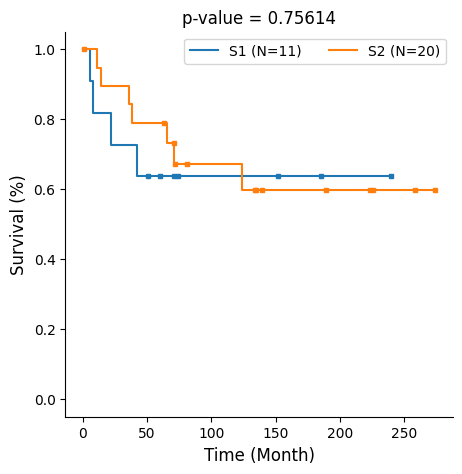

In [26]:
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
length_A, event_observed_A = (
            Length_cohort2_[Subgroup_ids_cohort2_ [:, 0] == 1],
            Status_cohort2_[Subgroup_ids_cohort2_ [:, 0] == 1],
    )
label = "S{} (N={})".format(1, np.sum(Subgroup_ids_cohort2_[:, 0] == 1))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[0],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})

length_B, event_observed_B = (
            Length_cohort2_[Subgroup_ids_cohort2_ [:, 1] == 1],
            Status_cohort2_[Subgroup_ids_cohort2_ [:, 1] == 1],
    )
label = "S{} (N={})".format(2, np.sum(Subgroup_ids_cohort2_[:, 1] == 1))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[1],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})

log_rank_test  = logrank_test(length_A, length_B, event_observed_A, event_observed_B)
       
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

#### Plot HR

/tmp/ipykernel_4072718/2811064137.py:42: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set(ylim = (0, 10))


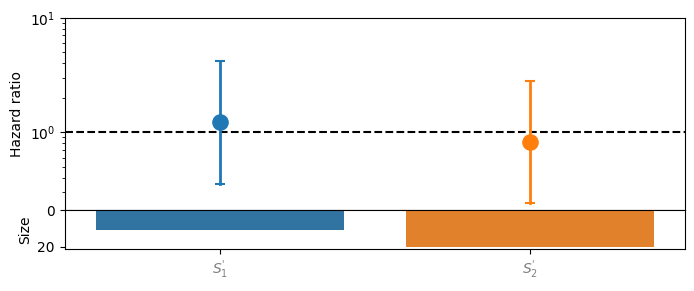

In [14]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    if np.sum(Subgroup_ids_cohort2_[:,i] ==1) >0:
        ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
        ax[0].scatter([i], [hr], color=color_palette[i], s=120)
        ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
        ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids_cohort2_[:,i] ==1))
    xticklabels.append("$S_{}^'$".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
ax[0].set(ylim = (0, 10))
plt.show()

## Jackson

#### Load Gram matrix and clinical data

In [33]:
from utils import process_Jackson_clinical_data
survival_type_jackson = "Overall"
SoftWL_dict_jackson = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_jackson = SoftWL_dict_jackson["Patient_id"]
Histograms_jackson = SoftWL_dict_jackson["Histogram"]
Histograms_jackson = Histograms_jackson/np.sum(Histograms_jackson, axis=1, keepdims=True)
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical = process_Jackson_clinical_data(clinical)

Patient_Inclusion_mask_jackson = np.ones(len(Patient_IDs_jackson), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_jackson]
    patient_inclusion_mask_jackson = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_jackson = Patient_Inclusion_mask_jackson * patient_inclusion_mask_jackson
Patient_IDs_jackson = np.array(Patient_IDs_jackson)[Patient_Inclusion_mask_jackson]
Histograms_jackson = Histograms_jackson[Patient_Inclusion_mask_jackson, :]

Length_jackson = [
        clinical.loc[clinical["patient_id"] == i, survival_type_jackson+" Survival (Months)"].values[0]
        for i in Patient_IDs_jackson
    ]
Status_jackson = [
        clinical.loc[clinical["patient_id"] == i, survival_type_jackson+" Survival Status"].values[0]
        for i in Patient_IDs_jackson
    ]

DF_jackson = pd.DataFrame({"Length": Length_jackson, "Status": Status_jackson}).dropna()
Length_jackson_ = np.array(DF_jackson["Length"])
Status_jackson_ = np.array(DF_jackson["Status"])
Histograms_jackson_ = Histograms_jackson[DF_jackson.index.values, :]
Patient_IDs_jackson_ = np.array(Patient_IDs_jackson)[DF_jackson.index.values]
print(len(Patient_IDs_jackson_))

45


#### Map subgroups

In [29]:
from b_Soft_WL_Kernel_random_split.SoftWL import get_Gram_matrix
from Alignment import centroid_alignment_based_on_similarity
Gram_matrix_jackson_ = get_Gram_matrix(Histograms_jackson_)
Similarity_jackson_discovery = get_Gram_matrix(np.concatenate([Histograms_jackson_, Histograms_], axis=0))[:Histograms_jackson_.shape[0], :][:, Histograms_jackson_.shape[0]:]
assert Similarity_jackson_discovery.shape[0] == Histograms_jackson_.shape[0]
Subgroup_ids_jackson_ = centroid_alignment_based_on_similarity(Similarity_jackson_discovery, Subgroup_ids_, k=1)


0.4560223330231643


#### Plot population graph

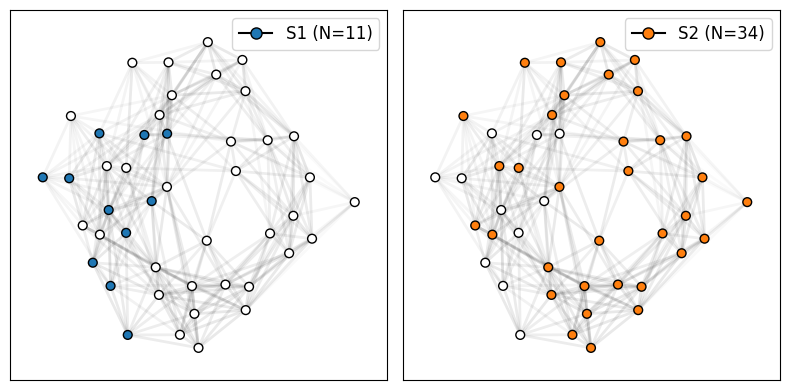

In [30]:
G_population_jackson_ = construct_PopulationGraph(
    Gram_matrix_jackson_,
    'knn_graph',
    para_dict = {
        'weight_threshold_percentile': 90,
        'knn_k':10
    },
)
color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
pos = nx.spring_layout(G_population_jackson_, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(1, Subgroup_ids_jackson_.shape[1], figsize=(4*Subgroup_ids_jackson_.shape[1],4), tight_layout=True)
for i in range(Subgroup_ids_cohort2_.shape[1]):
    subgroup_id = i + 1
    edge_list = list(G_population_jackson_.edges())
    edge_alpha = [
            0.1 * G_population_jackson_[u][v]["weight"] if G_population_jackson_[u][v]["weight"] > 0 else 0 for u, v in edge_list
        ]
    nx.draw_networkx_edges(G_population_jackson_, pos, alpha=edge_alpha, width=2, ax = ax[i])
    nx.draw_networkx_nodes(
                G_population_jackson_, pos, node_size=40, 
                node_color=[color_palette[subgroup_id] if j==1 else 'white' for j in Subgroup_ids_jackson_[:,i]], 
                edgecolors="black", ax = ax[i]
            )
    handles = [Line2D(
            [0],
            [0],
            marker="o",
            color = 'k',
            label=f"S{subgroup_id} (N={np.sum(Subgroup_ids_jackson_[:,i] == 1)})",
            markerfacecolor=color_palette[i+1],
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )]
    ax[i].legend(handles=handles, fontsize = 12)
plt.show()

#### Survival analysis

In [31]:
Length = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs_jackson_]
Status = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs_jackson_]  
HR_jackson = []
for i in range(Subgroup_ids_jackson_.shape[1]):
    HR_ = calculate_hazard_ratio(Length, Status, Subgroup_ids_jackson_[:,i])
    # print(HR_)
    HR_jackson.append({
        'subgroup_id': i + 1,
        'hr': HR_[0]['hr'],
        'hr_lower': HR_[0]['hr_lower'],
        'hr_upper': HR_[0]['hr_upper'],
        'p': HR_[0]['p']

    })

for i in range(len(HR_jackson)):
    print("S{} (N = {}):".format(HR_jackson[i]['subgroup_id'], np.sum(Subgroup_ids_jackson_[:,i] ==1)))
    print("Survival: hr = {}, p = {}".format(HR_jackson[i]["hr"], HR_jackson[i]["p"]))
    if HR_jackson[i]["p"] < 0.05/len(HR):
        print("\tSignificant")

S1 (N = 11):
Survival: hr = 2.795912938593026, p = 0.04778955211345041
S2 (N = 34):
Survival: hr = 0.3576649280442993, p = 0.04778955211345041


#### Plot HR

/tmp/ipykernel_4072718/2522192331.py:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set(ylim = (0, 10))


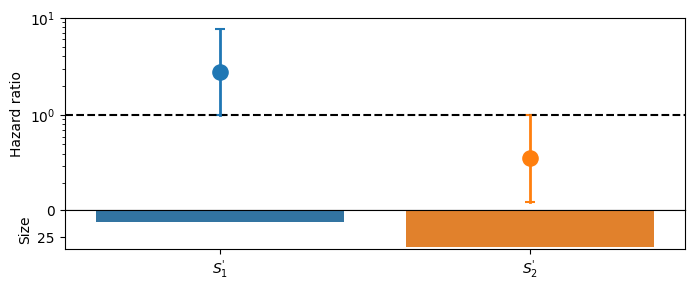

In [19]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR_jackson)):
    hr_dict = HR_jackson[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(np.sum(Subgroup_ids_jackson_[:,i] ==1)))
    xticklabels.append("$S_{}^'$".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
ax[0].set(ylim = (0, 10))
plt.show()

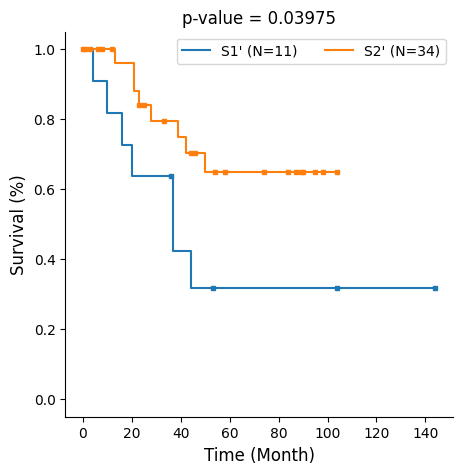

In [34]:
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
length_A, event_observed_A = (
            Length_jackson_[Subgroup_ids_jackson_ [:, 0] == 1],
            Status_jackson_[Subgroup_ids_jackson_ [:, 0] == 1],
    )
label = "S{}' (N={})".format(1, np.sum(Subgroup_ids_jackson_[:, 0] == 1))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[0],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})

length_B, event_observed_B = (
            Length_jackson_[Subgroup_ids_jackson_ [:, 1] == 1],
            Status_jackson_[Subgroup_ids_jackson_ [:, 1] == 1],
    )
label = "S{}' (N={})".format(2, np.sum(Subgroup_ids_jackson_[:, 1] == 1))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[1],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})

log_rank_test  = logrank_test(length_A, length_B, event_observed_A, event_observed_B)
       
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()